# 네이버 뉴스 크롤링

In [ ]:
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import pandas as pd
import re
import time
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''
< naver 뉴스 검색시 리스트 크롤링하는 프로그램 > _select사용
- 크롤링 해오는 것 : 링크,제목,신문사,날짜,내용요약본
- 날짜,내용요약본  -> 정제 작업 필요
- 리스트 -> 딕셔너리 -> df -> 엑셀로 저장 
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''

#각 크롤링 결과 저장하기 위한 리스트 선언 
title_text=[]
link_text=[]
source_text=[]
date_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
RESULT_PATH ='~/Desktop/'  #결과 저장할 경로 (바탕화면에 저장됨)

now = datetime.now() #파일이름 현 시간으로 저장하기

#날짜 정제화 함수
def date_cleansing(test):
    try:
        #지난 뉴스
        #머니투데이  10면1단  2018.11.05.  네이버뉴스   보내기  
        pattern = '\d+.(\d+).(\d+).'  #정규표현식 
    
        r = re.compile(pattern)
        match = r.search(test).group(0)  # 2018.11.05.
        date_text.append(match)
        #print(match)
        
    except AttributeError:
        #최근 뉴스
        #이데일리  1시간 전  네이버뉴스   보내기  

        pattern = '(\d\w+\s\전)' #정규표현식 

        r = re.compile(pattern)
        match = r.search(test).group(0)
        #print(match)
        date_text.append(match)

#내용 정제화 함수 

def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '', 
                                      str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', 
                                       first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)
    

def crawler(maxpage,query,sort,s_date,e_date):

    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1  
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
    
    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        # url 주소에다 날짜를 입력할 예정
        
        response = requests.get(url)
        html = response.text

        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')
        #print(soup)
        #<a>태그에서 제목과 링크주소 추출
        
        atags = soup.select('.news_tit') # 뉴스기사의 제목 셀렉트
        
        for atag in atags:
            title_text.append(atag.text)     #제목 따오기
            link_text.append(atag['href'])   #링크주소 따오기
        
        #신문사 추출
        
        source_lists = soup.select('.press')
        
        for source_list in source_lists:
            if source_list.i:
                source_list.i.extract()
            if source_list.find('span') == None:
                continue
            source_text.append(source_list.text)    #신문사
            
        #날짜 추출 
        
        date_lists = soup.select('.info_group')
        #print(date_lists)
        
        for date_list in date_lists:
            if date_list.i:
                date_list.i.extract()
            test=date_list.text   
            
            date_cleansing(test)  #날짜 정제 함수사용 
            

        #본문요약본
        contents_lists = soup.select('.dsc_txt_wrap')
        for contents_list in contents_lists:
            #print('==='*40)
            #print(contents_list)
            contents_cleansing(contents_list) #본문요약 정제화
        
        
        #모든 리스트 딕셔너리형태로 저장
        
        # print(len(date_text), len(title_text), len(source_text), len(contents_text), len(link_text))
        result= {"date" : date_text , "title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }  
        
        #print(page)
        
        #print(result)
        df = pd.DataFrame(result)  #df로 변환
        page += 10
        #df
    
    
    # 새로 만들 파일이름 지정
    #outputFileName = '%s-%s-%s  %s시 %s분 %s초 merging.xlsx' % (now.year, now.month, now.day, now.hour, now.minute, now.second)
    
    outputFileName = query + ' %s-%s-%s  %s시 %s분.xlsx' % (now.year, now.month, now.day, now.hour, now.minute)
    
    df.to_excel(RESULT_PATH+outputFileName,sheet_name='sheet1')
    
    
    

def main():
    
    
    query = input("검색어 입력: ")  
    maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")  
    
    sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ") 
    s_date = input("시작날짜 입력(2020.02.18):") 
    e_date = input("끝날짜 입력(2020.02.18):")   
    
    
    crawler(maxpage,query,sort,s_date,e_date)
    
    print('크롤링 중입니다.')
    time.sleep(2) # 10초
    print('저장이 완료되었습니다.')
    
main()

검색어를 입력해주세요 :야식
시작페이지 설정: 1
마지막페이지 설정:10
출력빈도 TOP 설정4
url 수집 끝, 해당 url 데이터 크롤링


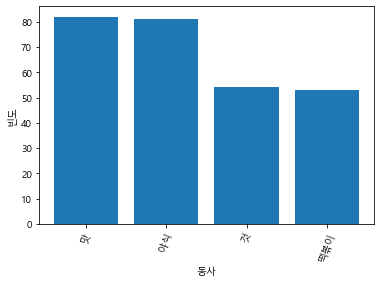

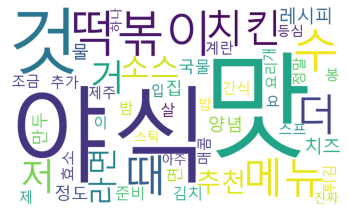

In [28]:
from selenium import webdriver
from nltk import Text
from konlpy.tag import *        #pip install konlpy 먼저 하세요
import matplotlib.pyplot as plt #pip install matplotlib 먼저 하세요
from matplotlib import font_manager , rc
from wordcloud import WordCloud  # pip install wordcloud 먼저 하세요
from collections import Counter
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time


text = input("검색어를 입력해주세요 :") # 검색어
text1 = int(input("시작페이지 설정: "))
text2 = int(input("마지막페이지 설정:"))
text3 = int(input("출력빈도 TOP 설정"))

path = "D:/00_Limhs/py_data/drv/chromedriver.exe" # 웹드라이버 실행
 
RESULT_PATH ='~/Desktop/' 


driver = webdriver.Chrome(path) # 드라이버 경로 설정
url_list = [] # 블로그 url을 저장하기 위한 변수
content_list = "" # 블로그 content를 누적하기 위한 변수


 
for i in range((text1),(text2)):  # 1~100페이지까지의 블로그 내용을 읽어옴
    url = 'https://section.blog.naver.com/Search/Post.nhn?pageNo='+ str(i) + '&rangeType=ALL&orderBy=sim&keyword=' + text # url 값 설정
    driver.get(url)
    time.sleep(0.5) # 오류 방지 sleep

    for j in range(1, 3):
        titles = driver.find_element_by_xpath('/html/body/ui-view/div/main/div/div/section/div[2]/div['+str(j)+']/div/div[1]/div[1]/a[1]')
        title = titles.get_attribute('href')
        url_list.append(title)

print("url 수집 끝, 해당 url 데이터 크롤링")
 
for url in url_list: # 저장했던 블로그 하나씩 순회
    driver.get(url)

    driver.switch_to.frame('mainFrame')
    overlays = ".se-component.se-text.se-l-default" # 내용 크롤링
    contents = driver.find_elements_by_css_selector(overlays)
     
    for content in contents:
        content_list = content_list + content.text # 각 블로그의 내용을 변수에 누적함

# 트위터에서 만든 소셜 분석을 위한 형태소 분석기 Okt 사용

okt = Okt()
kkma = Kkma( )
myList = okt.pos(content_list, norm=True, stem=True) # 모든 형태소 추출
myList_filter = [x for x, y in myList if y in ['Noun']] # 추출된 값 중 동사만 추출
  
Okt = Text(myList_filter, name="Okt")

#okt.pos(data1)

# 그래프에서 한글이 출력이 안되는 문제 해결 (ㅁㅁㅁ 처럼 출력됨)

font_location = "c:/Windows/Fonts/malgun.ttf"

font_name = font_manager.FontProperties(fname=font_location).get_name()

rc('font', family=font_name)
 
    
# 그래프 x, y 라벨 설정
plt.xlabel("key words")
plt.ylabel("빈도")
 
# 그래프에서 x, y 값을 설정

wordInfo = dict()
for tags, counts in Okt.vocab().most_common(text3): # 출력 갯수 제한
    
    if(len(str(tags)) > 0):
        wordInfo[tags] = counts

    values = sorted(wordInfo.values(), reverse=True)
    keys = sorted(wordInfo, key=wordInfo.get, reverse=True)

# 그래프 값 설정
plt.bar(range(len(wordInfo)), values, align='center')
plt.xticks(range(len(wordInfo)), list(keys), rotation='70')
plt.show()
 
# wordCloud 출력
wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_location, max_words=50)
plt.imshow(wc.generate_from_frequencies(Okt.vocab()))
plt.axis("off")
plt.show()

In [32]:
contents

[<selenium.webdriver.remote.webelement.WebElement (session="63b9b498c35770e92c65af32d5206da9", element="921cab4a-472d-48da-83bb-98d9c88ae920")>,
 <selenium.webdriver.remote.webelement.WebElement (session="63b9b498c35770e92c65af32d5206da9", element="d8b2d24a-ce03-4b36-b0ec-90096a537185")>,
 <selenium.webdriver.remote.webelement.WebElement (session="63b9b498c35770e92c65af32d5206da9", element="18e30de0-115e-424a-8f9e-d1ef70291517")>,
 <selenium.webdriver.remote.webelement.WebElement (session="63b9b498c35770e92c65af32d5206da9", element="97a3bf90-8d04-44f4-bfd6-6614e2b84d99")>,
 <selenium.webdriver.remote.webelement.WebElement (session="63b9b498c35770e92c65af32d5206da9", element="c0684ba3-8c8e-487f-a3ee-dc8327410c41")>,
 <selenium.webdriver.remote.webelement.WebElement (session="63b9b498c35770e92c65af32d5206da9", element="20f7a6e4-57c2-4c68-b06f-33909c200922")>,
 <selenium.webdriver.remote.webelement.WebElement (session="63b9b498c35770e92c65af32d5206da9", element="5e2beb17-da45-4243-b68a-04